# Importing Libraries

In [1]:
# For Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
from imblearn.over_sampling import SMOTE

# Import ML Model Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# For Model Evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc 
from matplotlib import pyplot

# Importing data

In [2]:
colectomy_cci_var = pd.read_csv('./colectomy_cci_var.csv', dtype = 'str')

# Formating datatype

In [3]:
colectomy_cci_var['adsource'].value_counts()

adsource
1    34198
2     3542
4      376
5      238
6      167
E       82
8       17
D        9
9        3
7        1
Name: count, dtype: int64

In [ ]:
# Set random seed
np.random.seed(42)

# Rename columns
colectomy_cci_var['ptsex'] = colectomy_cci_var['ptsex'].replace({'F': 'female', 'M': 'male'})
colectomy_cci_var['adtype'] = colectomy_cci_var['adtype'].replace({'1': 'emergency', '2': 'urgent', '3': 'elective'})
colectomy_cci_var['adsource'] = colectomy_cci_var['adsource'].replace({'1': 'non_healthcare_facility', '2': 'clinical_referral', '4': 'hospital_transfer', '5': 'snf_icf_transfer', '6': 'healthcare_facility_tranfer', '7': 'emergency_room', '8': 'court_law_enforcement', 'D': 'hospital_unit_transfer', 'E': 'ambulatory_surgery_center'})

colectomy_cci_var['age'] = colectomy_cci_var['age'].astype(int)

colectomy_cci_var['paytype1'] = colectomy_cci_var['paytype1'].fillna('99')

# Drop observations
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != '9']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'emergency_room']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'court_law_enforcement']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'hospital_unit_transfer']
#print(len(colectomy_cci_var))
colectomy_cci_var = colectomy_cci_var.groupby('pdx').filter(lambda x: len(x) >= 1000)
#print(len(colectomy_cci_var))

# Select Relevant Features
features = ['year', 'ptsex', 'race', 'age', 'adtype', 'adsource', 'admdx']
dummy_features = ['year','ptsex', 'race', 'adtype', 'adsource']

# Data Preprocessing
num_secondary_admissions = 10

for i in range(1, num_secondary_admissions + 1):
    sdx = f'sdx{i}'

    features.append(sdx)

    # Replace missing values with the "unknown" category
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].fillna('unknown')

    # Target encoding
    category_counts = colectomy_cci_var[sdx].value_counts()
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].map(category_counts)

# Target encoding
category_counts = colectomy_cci_var['admdx'].value_counts()
colectomy_cci_var['admdx'] = colectomy_cci_var['admdx'].map(category_counts)

#for feature in features:
#    print(colectomy_cci_var[feature].value_counts())


In [5]:
# Extracting categorical and numerical columns
cat_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype == 'object']
num_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype != 'object']


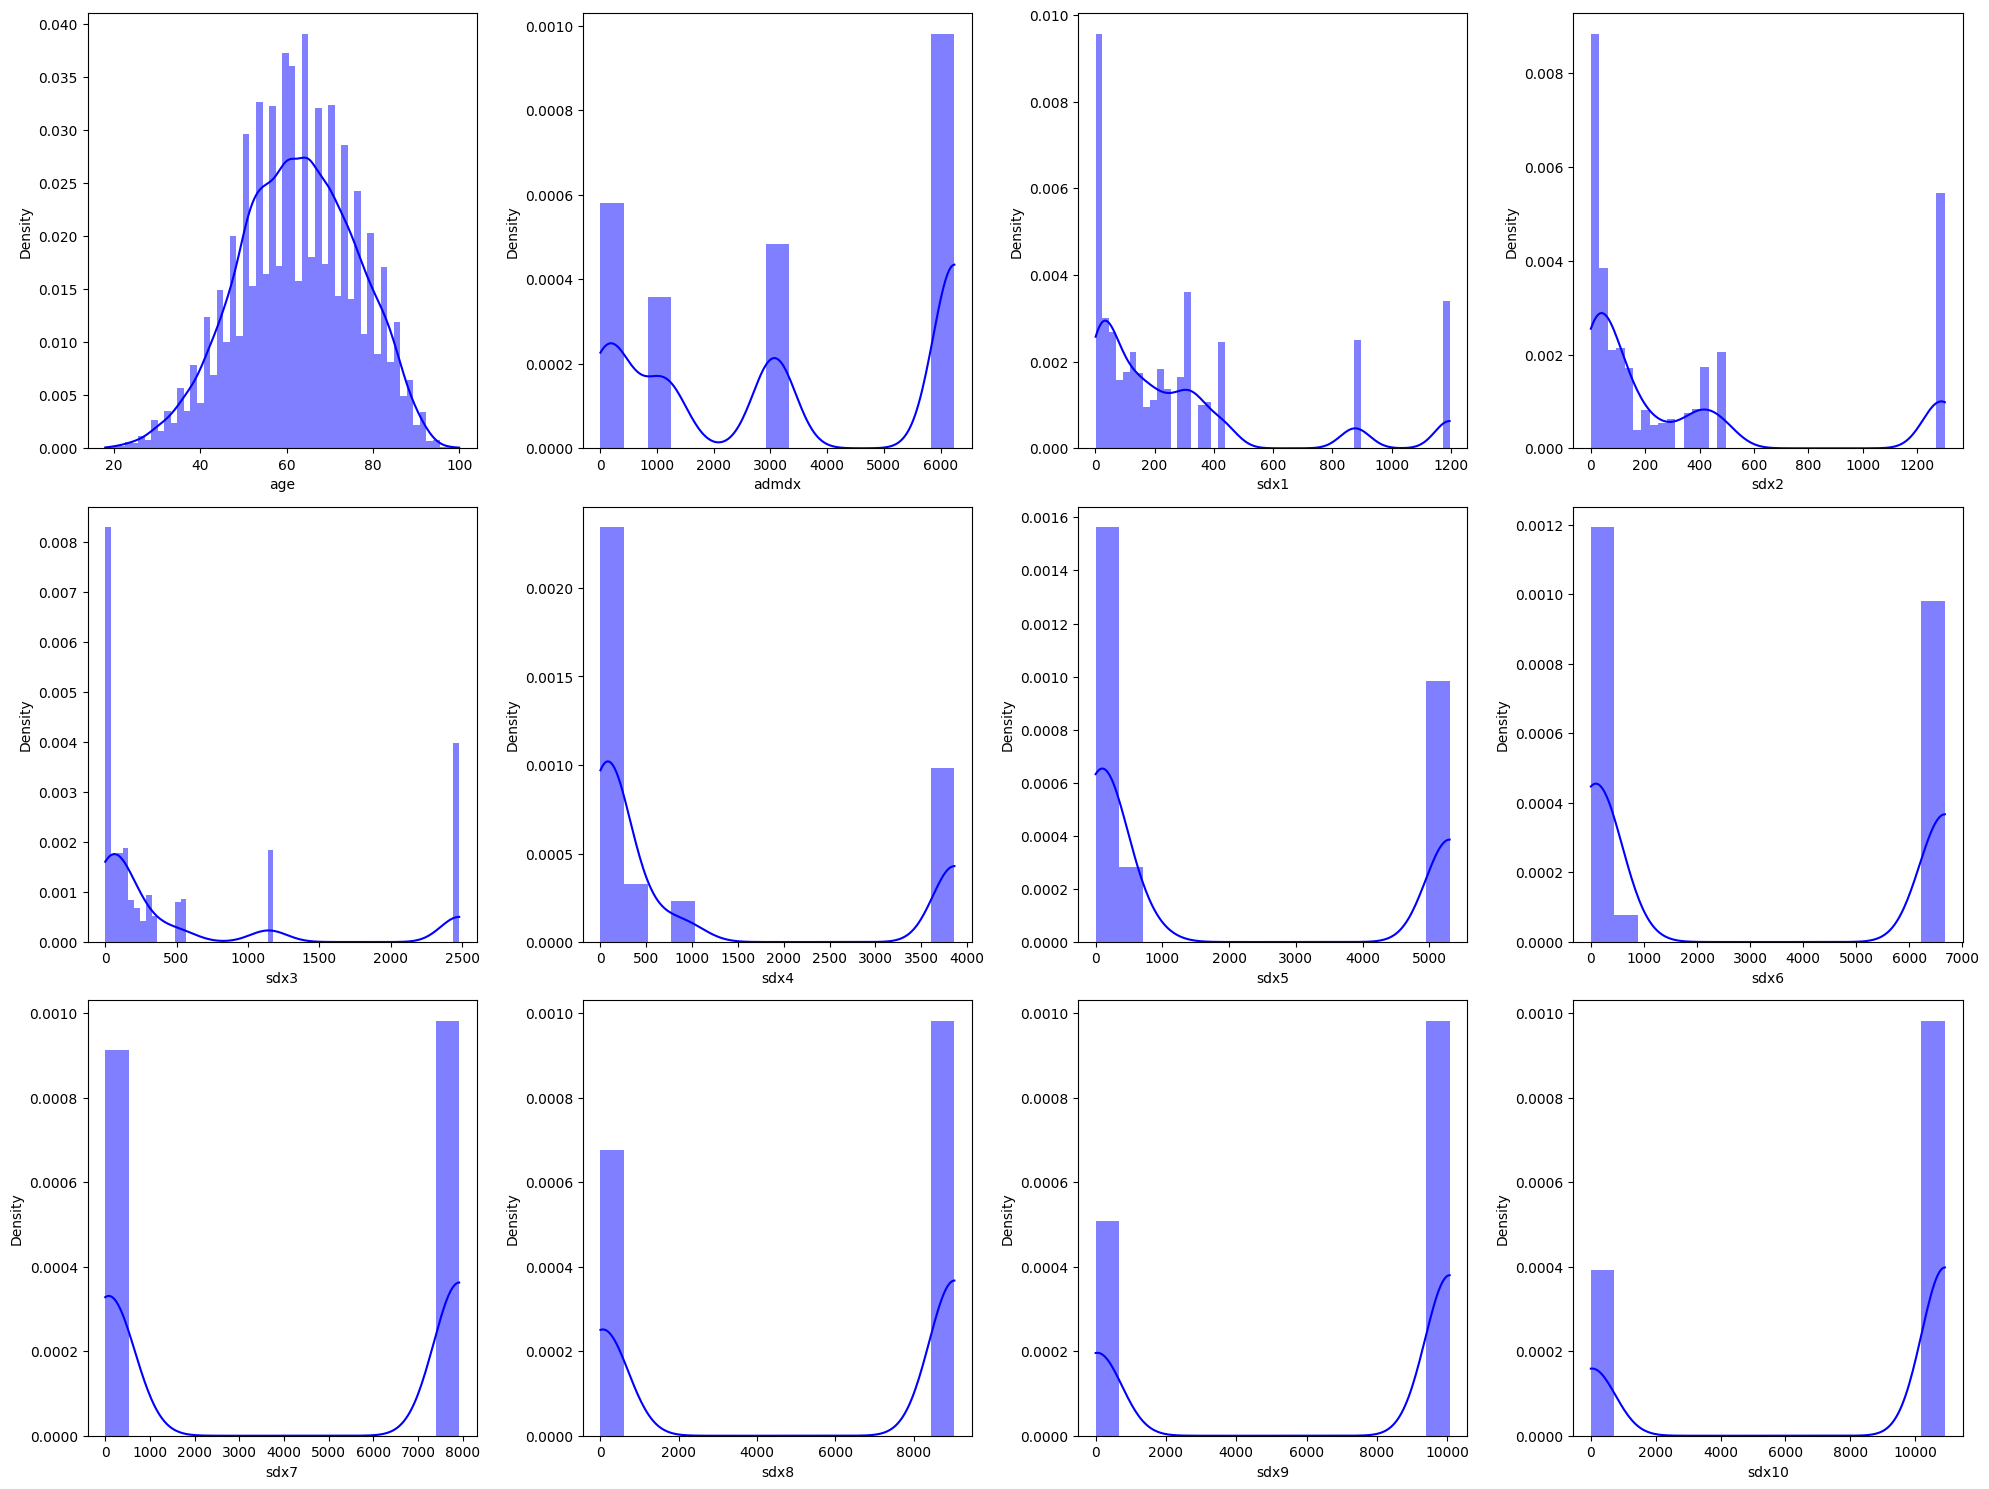

In [6]:
# checking numerical features distribution
plt.figure(figsize = (20, 15))
plotnumber = 1
for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 4, plotnumber)
        sns.histplot (colectomy_cci_var[column], color = 'blue', kde = True, stat = "density", linewidth = 0)
        plt.xlabel(column)
    
        
    plotnumber += 1

plt.tight_layout()
plt.show()

/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_38259/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_38259/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_38259/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.cou

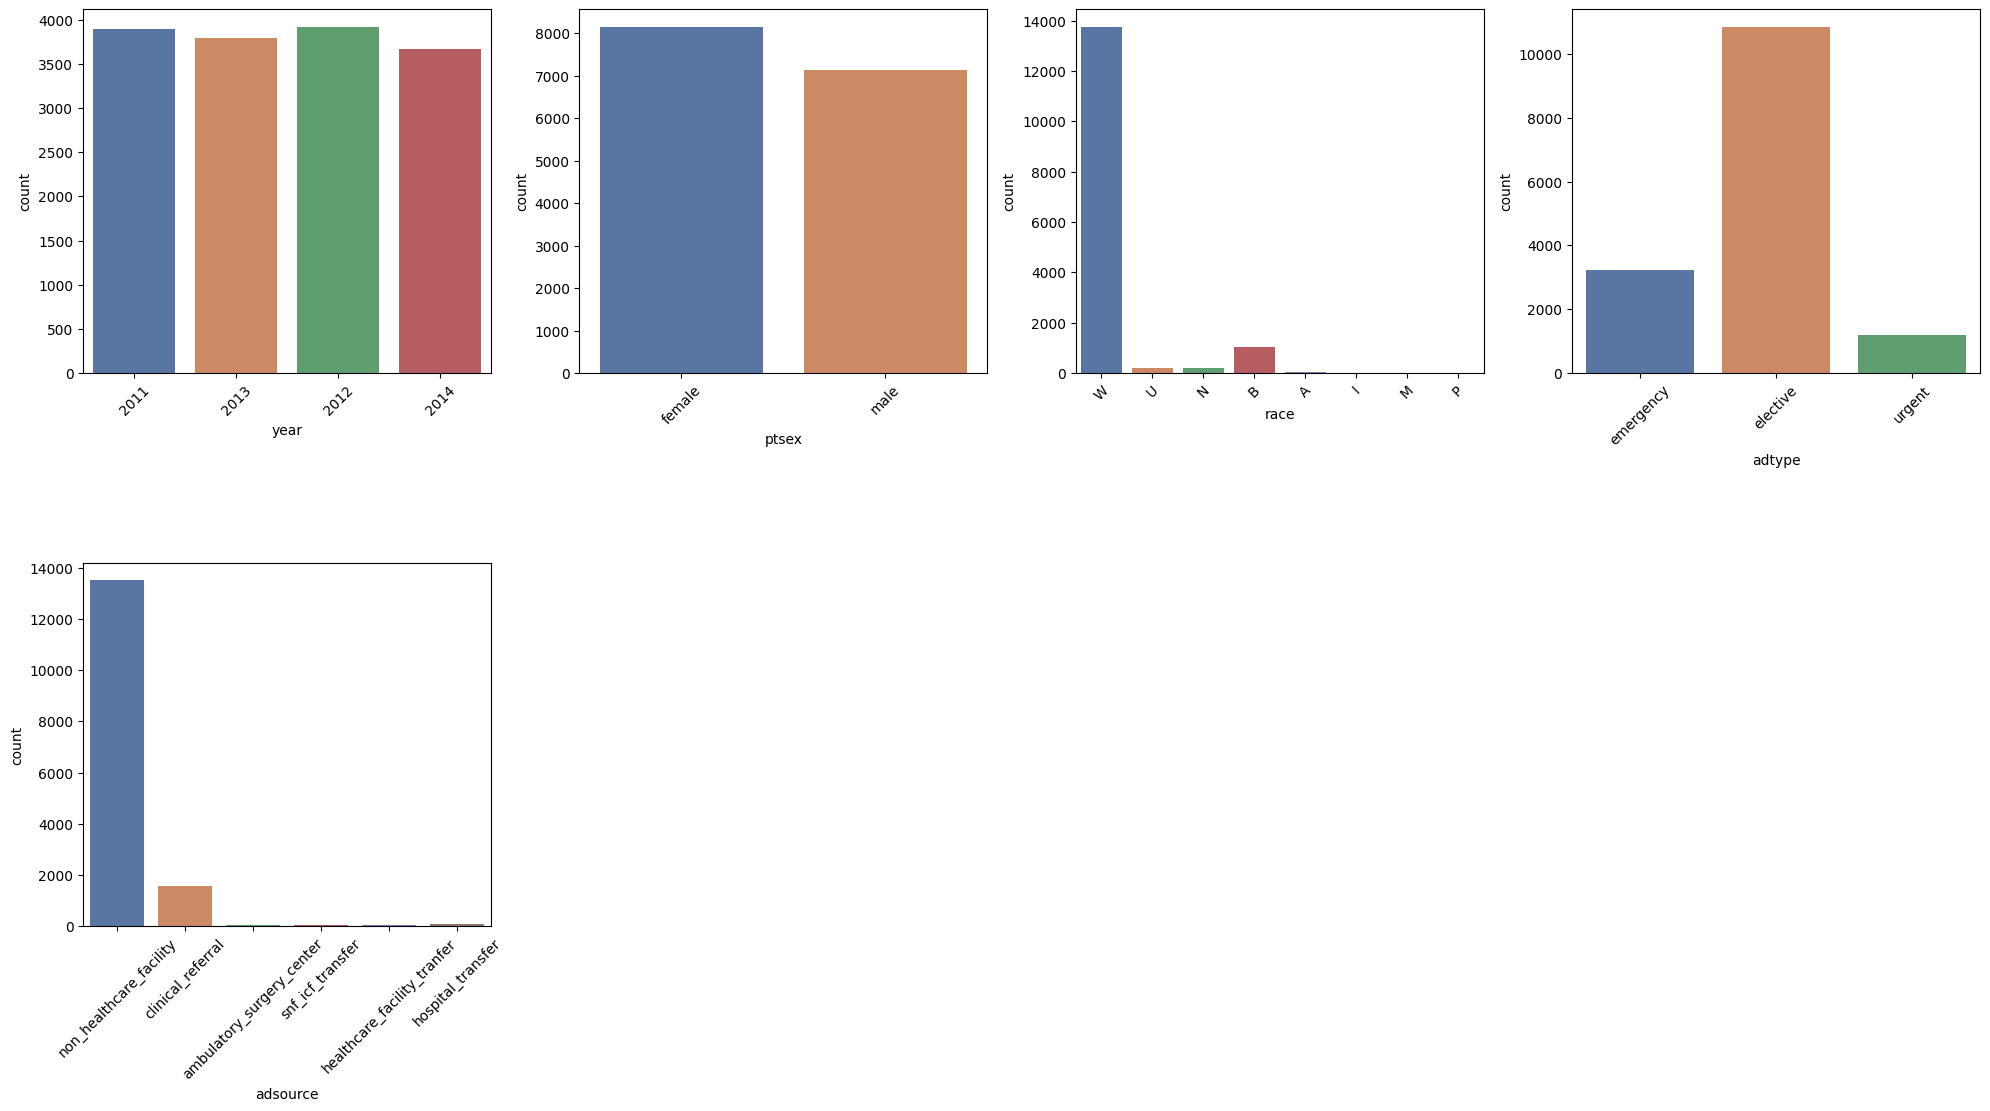

In [7]:
# looking at categorical columns

plt.figure(figsize = (20, 15))
plotnumber = 1
for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
        plt.xlabel(column)
        plt.xticks(rotation = 45)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [8]:
colectomy_cci_var_X = colectomy_cci_var[features]
colectomy_cci_var_y = colectomy_cci_var['pdx']

# One-Hot Encoding
colectomy_cci_var_X = pd.get_dummies(colectomy_cci_var_X, columns = dummy_features)

# Split Data
train_X, test_X, train_y, test_y = train_test_split(colectomy_cci_var_X, colectomy_cci_var_y, test_size = 0.2, random_state = 0)

# Data Resampling
#smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
#train_X, train_y = smote.fit_resample(train_X, train_y)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_normalized = train_X.copy()
test_X_normalzied = test_X.copy()

normalizer = scaler.fit(train_X_normalized[normalize_features])

train_X_normalized[normalize_features] = normalizer.transform(train_X_normalized[normalize_features])
test_X_normalzied[normalize_features] = normalizer.transform(test_X_normalzied[normalize_features])

In [9]:
# Split the training set into Medicare, Medicaid, Government Health Insurance
#colectomy_cci_var_public = colectomy_cci_var[colectomy_cci_var['paytype1'].str.startswith(('1', '2', '8'))]
# Split the test set into Uninsured, Blue Cross, Commercial, leave out the Unknown insurance group
#colectomy_cci_var_private_other = colectomy_cci_var[colectomy_cci_var['paytype1'].str.startswith(('0', '3', '4'))]

# Split the training set into patients below the age of 60
colectomy_cci_var_public = colectomy_cci_var[colectomy_cci_var['age'] < 60]
# Split the testing set into patients above the age of 60
colectomy_cci_var_private_other = colectomy_cci_var[colectomy_cci_var['age'] >= 60]

print(f"Length of training set: {len(colectomy_cci_var_public)}")
print(f"Length of testing set: {len(colectomy_cci_var_private_other)}")

train_X_OOD = colectomy_cci_var_public[features]
train_y_OOD = colectomy_cci_var_public['pdx'] 
test_X_OOD = colectomy_cci_var_private_other[features]
test_y_OOD = colectomy_cci_var_private_other['pdx']

# One-Hot Encoding
train_X_OOD = pd.get_dummies(train_X_OOD, columns = dummy_features)
test_X_OOD = pd.get_dummies(test_X_OOD, columns = dummy_features)

# Data Resampling
# Change variable names to OOD if this gets used
#smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
#train_X, train_y = smote.fit_resample(train_X, train_y)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y_OOD)
train_y_OOD = label_encoder.transform(train_y_OOD)
test_y_OOD = label_encoder.transform(test_y_OOD)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_OOD_normalized = train_X_OOD.copy()
test_X_OOD_normalzied = test_X_OOD.copy()

normalizer = scaler.fit(train_X_OOD_normalized[normalize_features])

train_X_OOD_normalized[normalize_features] = normalizer.transform(train_X_OOD_normalized[normalize_features])
test_X_OOD_normalzied[normalize_features] = normalizer.transform(test_X_OOD_normalzied[normalize_features])

Length of training set: 6274
Length of testing set: 9009


In [10]:
X_train = train_X_normalized
X_test = test_X_normalzied
Y_train = train_y
Y_test = test_y

In [11]:
X_train_OOD = train_X_OOD_normalized
X_test_OOD = test_X_OOD_normalzied
Y_train_OOD = train_y_OOD
Y_test_OOD = test_y_OOD

# Training Models

In [12]:
# Random Forest
clf_rand_forest = RandomForestClassifier()
clf_rand_forest.fit(X_train, Y_train)

RandomForestClassifier()

In [13]:
# SVM
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(X_train, Y_train)

SVC(kernel='linear')

In [14]:
# Naive Bayes
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, Y_train)

GaussianNB()

In [15]:
# Logistic Regression
clf_log = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log.fit(X_train, Y_train)

LogisticRegression(max_iter=2500)

In [16]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [17]:
# XG Boost
clf_xgb = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [18]:
# Decision Tree
clf_dtc = DecisionTreeClassifier()
clf_dtc.fit(X_train, Y_train)

DecisionTreeClassifier()

In [19]:
# Ada Boost
clf_ada = AdaBoostClassifier(estimator = clf_dtc)
clf_ada.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

# Training OOD Models

In [20]:
# Random Forest
clf_rand_forest_OOD = RandomForestClassifier()
clf_rand_forest_OOD.fit(X_train_OOD, Y_train_OOD)

RandomForestClassifier()

In [21]:
# SVM
clf_svm_OOD = svm.SVC(kernel = 'linear')
clf_svm_OOD.fit(X_train_OOD, Y_train_OOD)

SVC(kernel='linear')

In [22]:
# Naive Bayes
clf_gnb_OOD = GaussianNB()
clf_gnb_OOD.fit(X_train_OOD, Y_train_OOD)

GaussianNB()

In [23]:
# Logistic Regression
clf_log_OOD = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log_OOD.fit(X_train_OOD, Y_train_OOD)

LogisticRegression(max_iter=2500)

In [24]:
# KNN
clf_knn_OOD = KNeighborsClassifier(n_neighbors = 5)
clf_knn_OOD.fit(X_train_OOD, Y_train_OOD)

KNeighborsClassifier()

In [25]:
# XG Boost
clf_xgb_OOD = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb_OOD.fit(X_train_OOD, Y_train_OOD)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [26]:
# Decision Tree
clf_dtc_OOD = DecisionTreeClassifier()
clf_dtc_OOD.fit(X_train_OOD, Y_train_OOD)

DecisionTreeClassifier()

In [27]:
# Ada Boost
clf_ada_OOD = AdaBoostClassifier(estimator = clf_dtc_OOD)
clf_ada_OOD.fit(X_train_OOD, Y_train_OOD)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

# Evaluation

### Random Forest

#### Classification Report

In [28]:
Y_pred = clf_rand_forest.predict(X_test)

rand_forest_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {rand_forest_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8786391887471378
Mean Absolute Error: 0.17206411514556755
Mean Squared Error: 0.27347072293097807
Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       536
           1       0.85      0.85      0.85       737
           2       0.93      0.93      0.93      1784

    accuracy                           0.88      3057
   macro avg       0.84      0.84      0.84      3057
weighted avg       0.88      0.88      0.88      3057



### SVM

#### Classification Report

In [29]:
Y_pred = clf_svm.predict(X_test)

svm_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {svm_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.82564605822702
Mean Absolute Error: 0.27314360484134775
Mean Squared Error: 0.4707229309780831
Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.82      0.64       536
           1       0.94      0.73      0.82       737
           2       0.93      0.87      0.90      1784

    accuracy                           0.83      3057
   macro avg       0.80      0.81      0.79      3057
weighted avg       0.87      0.83      0.84      3057



### Naive Bayes

#### Classification Report

In [30]:
Y_pred = clf_gnb.predict(X_test)

gnb_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {gnb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.465161923454367
Mean Absolute Error: 0.5966633954857704
Mean Squared Error: 0.7203140333660452
Classification Report: 
              precision    recall  f1-score   support

           0       0.40      0.24      0.30       536
           1       0.33      0.94      0.49       737
           2       0.94      0.34      0.50      1784

    accuracy                           0.47      3057
   macro avg       0.56      0.51      0.43      3057
weighted avg       0.70      0.47      0.46      3057



### Logistic Regression

#### Classification Report

In [31]:
Y_pred = clf_log.predict(X_test)

log_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {log_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.7396140006542362
Mean Absolute Error: 0.328426561988878
Mean Squared Error: 0.46450768727510633
Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       536
           1       0.60      0.59      0.60       737
           2       0.85      0.86      0.86      1784

    accuracy                           0.74      3057
   macro avg       0.66      0.66      0.66      3057
weighted avg       0.74      0.74      0.74      3057



### KNN

#### Classification Report

In [32]:
Y_pred = clf_knn.predict(X_test)

knn_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {knn_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.7726529277069022
Mean Absolute Error: 0.3251553810925744
Mean Squared Error: 0.5207719986915277
Classification Report: 
              precision    recall  f1-score   support

           0       0.51      0.58      0.54       536
           1       0.72      0.75      0.74       737
           2       0.89      0.84      0.86      1784

    accuracy                           0.77      3057
   macro avg       0.71      0.72      0.71      3057
weighted avg       0.78      0.77      0.78      3057



### XG_Boost

#### Classification Report

In [33]:
Y_pred = clf_xgb.predict(X_test)

xgb_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {xgb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.9103696434412824
Mean Absolute Error: 0.11481844946025516
Mean Squared Error: 0.16519463526333006
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       536
           1       0.86      0.87      0.87       737
           2       0.95      0.96      0.95      1784

    accuracy                           0.91      3057
   macro avg       0.88      0.88      0.88      3057
weighted avg       0.91      0.91      0.91      3057



### Decision Tree

#### Classification Report

In [34]:
Y_pred = clf_dtc.predict(X_test)

dtc_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {dtc_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8541053320248609
Mean Absolute Error: 0.19267255479228002
Mean Squared Error: 0.286228328426562
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       536
           1       0.79      0.81      0.80       737
           2       0.93      0.91      0.92      1784

    accuracy                           0.85      3057
   macro avg       0.81      0.82      0.81      3057
weighted avg       0.86      0.85      0.86      3057



### Ada Boost

#### Classification Report

In [35]:
Y_pred = clf_ada.predict(X_test)

ada_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {ada_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8563951586522734
Mean Absolute Error: 0.19234543670264967
Mean Squared Error: 0.28982662741249593
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       536
           1       0.79      0.82      0.81       737
           2       0.93      0.91      0.92      1784

    accuracy                           0.86      3057
   macro avg       0.81      0.82      0.81      3057
weighted avg       0.86      0.86      0.86      3057



# Model Comparison

In [36]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier'],
    'Score' : [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title = 'Models Comparison')

fig.show()

In [37]:
Y_pred = clf_rand_forest_OOD.predict(X_test_OOD)

rand_forest_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {rand_forest_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.7862137862137862
Mean Absolute Error: 0.3194583194583195
Mean Squared Error: 0.5308025308025308
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.40      0.56      2295
           1       0.80      0.86      0.83      2686
           2       0.76      0.96      0.85      4028

    accuracy                           0.79      9009
   macro avg       0.82      0.74      0.74      9009
weighted avg       0.81      0.79      0.77      9009



In [38]:
Y_pred = clf_svm_OOD.predict(X_test_OOD)

svm_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {svm_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.7797757797757797
Mean Absolute Error: 0.3450993450993451
Mean Squared Error: 0.5948495948495949
Classification Report: 
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      2295
           1       0.94      0.73      0.82      2686
           2       0.79      0.90      0.84      4028

    accuracy                           0.78      9009
   macro avg       0.78      0.75      0.76      9009
weighted avg       0.79      0.78      0.78      9009



In [39]:
Y_pred = clf_gnb_OOD.predict(X_test_OOD)

gnb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {gnb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.333999333999334
Mean Absolute Error: 0.8967698967698968
Mean Squared Error: 1.3583083583083584
Classification Report: 
              precision    recall  f1-score   support

           0       0.32      0.98      0.49      2295
           1       0.01      0.01      0.01      2686
           2       0.95      0.19      0.31      4028

    accuracy                           0.33      9009
   macro avg       0.43      0.39      0.27      9009
weighted avg       0.51      0.33      0.27      9009



In [40]:
Y_pred = clf_log_OOD.predict(X_test_OOD)

log_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {log_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.6686646686646687
Mean Absolute Error: 0.38461538461538464
Mean Squared Error: 0.4911754911754912
Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.21      0.30      2295
           1       0.52      0.86      0.65      2686
           2       0.87      0.81      0.84      4028

    accuracy                           0.67      9009
   macro avg       0.65      0.62      0.59      9009
weighted avg       0.69      0.67      0.64      9009



In [41]:
Y_pred = clf_knn_OOD.predict(X_test_OOD)

knn_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {knn_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.6462426462426463
Mean Absolute Error: 0.46575646575646573
Mean Squared Error: 0.6897546897546898
Classification Report: 
              precision    recall  f1-score   support

           0       0.52      0.26      0.34      2295
           1       0.59      0.63      0.61      2686
           2       0.71      0.88      0.78      4028

    accuracy                           0.65      9009
   macro avg       0.61      0.59      0.58      9009
weighted avg       0.62      0.65      0.62      9009



In [42]:
Y_pred = clf_xgb_OOD.predict(X_test_OOD)

xgb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {xgb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8620268620268621
Mean Absolute Error: 0.19502719502719504
Mean Squared Error: 0.3091353091353091
Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.68      0.77      2295
           1       0.87      0.86      0.86      2686
           2       0.84      0.97      0.90      4028

    accuracy                           0.86      9009
   macro avg       0.87      0.84      0.85      9009
weighted avg       0.87      0.86      0.86      9009



In [43]:
Y_pred = clf_dtc_OOD.predict(X_test_OOD)

dtc_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {dtc_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8266178266178266
Mean Absolute Error: 0.23676323676323677
Mean Squared Error: 0.3635253635253635
Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      2295
           1       0.80      0.84      0.82      2686
           2       0.87      0.91      0.89      4028

    accuracy                           0.83      9009
   macro avg       0.81      0.80      0.81      9009
weighted avg       0.82      0.83      0.82      9009



In [44]:
Y_pred = clf_ada_OOD.predict(X_test_OOD)

ada_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {ada_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8295038295038295
Mean Absolute Error: 0.23365523365523366
Mean Squared Error: 0.35997335997336
Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      2295
           1       0.81      0.84      0.82      2686
           2       0.86      0.92      0.89      4028

    accuracy                           0.83      9009
   macro avg       0.82      0.81      0.81      9009
weighted avg       0.83      0.83      0.83      9009



In [45]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier'],
    'Score' : [rand_forest_acc_OOD, svm_acc_OOD, gnb_acc_OOD, knn_acc_OOD, xgb_acc_OOD, dtc_acc_OOD, ada_acc_OOD]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title=  'Models Comparison')

fig.show()

In [46]:
importances = clf_rand_forest_OOD.feature_importances_

# Sort and display feature importances
sorted_idx = importances.argsort()
for idx in sorted_idx:
    print(f"Feature: {X_train.columns[idx]}, Importance: {importances[idx]}")

Feature: adsource_ambulatory_surgery_center, Importance: 0.00010606814082205127
Feature: race_M, Importance: 0.000127085817067784
Feature: adsource_snf_icf_transfer, Importance: 0.00015893822400366446
Feature: adsource_healthcare_facility_tranfer, Importance: 0.000270042205424872
Feature: race_P, Importance: 0.00029206037548926443
Feature: race_I, Importance: 0.0003776555864196874
Feature: race_A, Importance: 0.0005236531943936479
Feature: adsource_hospital_transfer, Importance: 0.000631578877932982
Feature: race_U, Importance: 0.0015064737402698796
Feature: race_N, Importance: 0.002563536368925122
Feature: adtype_urgent, Importance: 0.004654284230218079
Feature: adsource_non_healthcare_facility, Importance: 0.005137023974163526
Feature: adsource_clinical_referral, Importance: 0.005376248983168793
Feature: race_B, Importance: 0.006549004434970868
Feature: ptsex_male, Importance: 0.006961686639248377
Feature: race_W, Importance: 0.007406609790164398
Feature: ptsex_female, Importance: 0.

In [47]:
models = [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier']
ID_accuracies = [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc]
OOD_accuracies = [rand_forest_acc_OOD, svm_acc_OOD, gnb_acc_OOD, knn_acc_OOD, xgb_acc_OOD, dtc_acc_OOD, ada_acc_OOD]

for i in range(len(models)):
    difference = ID_accuracies[i] - OOD_accuracies[i]
    print(f"{models[i]} Difference: {difference}")

Random Forest Classifier Difference: 0.09242540253335152
SVM Classifier Difference: 0.045870278451240254
Naive Bayes Classifier Difference: 0.131162589455033
KNN Classifier Difference: 0.12641028146425592
XG_Boost Classifier Difference: 0.04834278141442028
Decision Tree Classifier Difference: 0.027487505407034374
Ada_Boost Classifier Difference: 0.026891329148443943
